In [25]:
import sys
sys.path.append('../src')

In [26]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

In [27]:
from gait.config import pd
from gait.utils import get_overlap_data_all_sessions, split_test_train_by_subjects
from gait.training import train_model, timeseries_shapes
from gait.evalution import save_history, save_test_history, save_accuracy_loss_figure, save_confusion_matrix_figure, compute_validations_predictions

In [28]:
def data_for_subject(X, y, unique_subjects, sub_id):
    ix = [i for i in range(len(unique_subjects)) if unique_subjects[i] == sub_id]
    return X[ix, :, :], y[ix]

['0DXZFsYOfgqsYe0Z' '0UXFxu10k0En1vDK' '19AoxD1bgrDckd2p'
 '1ZstYhEKzKKfGnMW' 'AlOXZjo87HHkXeaa' 'EUbKPOSQgjccjtvi'
 'I1TuySg6fbJ0xeXt' 'KNmC3LADpLyH5qJA' 'KPJOUYXzpivbLfsH'
 'LLZjAPTyj7muHsEf' 'LdH95bTaViXIdDBZ' 'MMuX9YIh4NTbLZLM'
 'NKdnm6cN3KKAx7R4' 'PE8D53oX060qLbdX' 'QFxq3HxMCbzs6bCt'
 'WAb2Ztvv2ux95P4Q' 'YbJVcb4vFFjKKlfe' 'bQsRwKxgJiXTzo6P'
 'c9EB3mOQckRCc8Bz' 'cbOZWnI7s1y8oLD4' 'csujYZktn88ftTTv'
 'eqUcL0HkHZfDt0Xs' 'ewpnQDEzR8hTqPRY' 'kPNKVxgIznp3Vskg'
 'psiuhPJmLIa2wC4u' 'qyP4saGxcV9UfeQI' 'sUZBISq61Y7I5tqQ'
 'wtyNo4LYaWXrkzA7' 'xYdtS1F8tDyjEIgN' 'zOmNofnVfbR21Y7n']
_____________________________________
_____________________________________
_____________________________________
_____________________________________


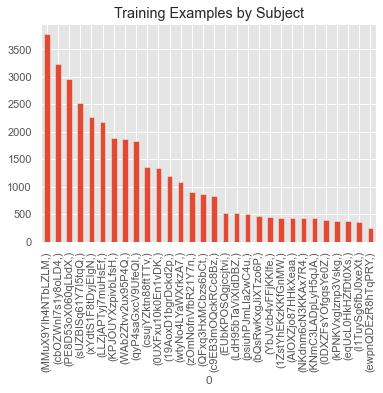

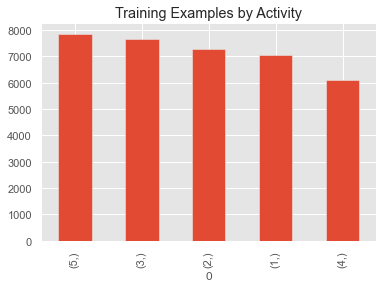

In [29]:
OVERLAP_PERCENT = 0
exclude_subjects = ['ddAeJA42PXvwthbW', 'nan']

X, y, subjects = get_overlap_data_all_sessions(OVERLAP_PERCENT)

indexes = np.where(subjects == exclude_subjects)
X = np.delete(X, indexes[0], axis=0)
y = np.delete(y, indexes[0], axis=0)
subjects = np.delete(subjects, indexes[0], axis=0)
print(np.unique(subjects))
print('_____________________________________')
print('_____________________________________')
print('_____________________________________')
print('_____________________________________')
sns.set()
plt.style.use('ggplot')
subject_df = pd.DataFrame(subjects)
subject_df.value_counts().plot(kind='bar',
                               title='Training Examples by Subject')
plt.show()
activity_df = pd.DataFrame(y)
activity_df.value_counts().plot(kind="bar", title="Training Examples by Activity")
plt.show()


In [30]:
print(X.shape)
print(y.shape)
print(subjects.shape)
unique_subjects = np.unique(subjects.shape)


(36007, 128, 9)
(36007, 1)
(36007, 1)


In [31]:
def class_breakdown(data):
    # convert the numpy array into a dataframe
    df = pd.DataFrame(data)
    # group data by the class value and calculate the number of rows
    counts = df.groupby(0).size()
    # retrieve raw rows
    counts = counts.values
    # summarize
    for i in range(len(counts)):
        percent = counts[i] / len(df) * 100
        print('Class=%d, total=%d, percentage=%.3f' % (i+1, counts[i], percent))

def compute_resultant_acceleration(X):
    return np.sqrt(X[:,:,0] **2 + X[:,:,1] ** 2 + X[:,:,2] ** 2)

def compute_resultant_gyro(X):
    return np.sqrt(X[:,:,3] **2 + X[:,:,4] ** 2 + X[:,:,5] ** 2)

def compute_resultant_angle(X):
    return np.sqrt(X[:,:,6] **2 + X[:,:,7] ** 2 + X[:,:,8] ** 2)

In [32]:
indexes = np.where(subjects == exclude_subjects)
X = np.delete(X, indexes[0], axis=0)
y = np.delete(y, indexes[0], axis=0)
subjects = np.delete(subjects, indexes[0], axis=0)

In [33]:
### NORMALIZE
def normalize_accelerometer(X):
    X[:, :, 0] = X[:, :, 0] / X[:, :, 0].max()
    X[:, :, 1] = X[:, :, 1] / X[:, :, 1].max()
    X[:, :, 2] = X[:, :, 2] / X[:, :, 2].max()
    return X

def normalize_gyro(X):
    X[:, :, 3] = (X[:, :, 3] / X[:, :, 3].max() )
    X[:, :, 4] = (X[:, :, 4] / X[:, :, 4].max() )
    X[:, :, 5] = (X[:, :, 5] / X[:, :, 5].max() )
    return X

def normalize_radians(X):
    X[:, :, 6] = (X[:, :, 6] / X[:, :, 6].max() )
    X[:, :, 7] = (X[:, :, 7] / X[:, :, 7].max() )
    X[:, :, 8] = (X[:, :, 8] / X[:, :, 8].max() )
    return X

In [34]:
# X = normalize_accelerometer(X)
# X = normalize_gyro(X)
# X = normalize_radians(X)

In [35]:
resultant_acc = compute_resultant_acceleration(X)
resultant_gyro = compute_resultant_gyro(X)
resultant_angle = compute_resultant_angle(X)
resultant_acc = resultant_acc.reshape(
    resultant_acc.shape[0], resultant_acc.shape[1], 1)
resultant_gyro = resultant_gyro.reshape(
    resultant_gyro.shape[0], resultant_gyro.shape[1], 1)
resultant_angle = resultant_angle.reshape(
    resultant_angle.shape[0], resultant_angle.shape[1], 1)
X = np.concatenate((X, resultant_acc), axis=2)
X = np.concatenate((X, resultant_gyro), axis=2)
X = np.concatenate((X, resultant_angle), axis=2)

In [36]:
X_train, X_test, y_train, y_test, y_train_non_encoded, y_test_non_encoded = split_test_train_by_subjects(
    X, y, subjects, train_percent=0.8)

print('Train Dataset')
class_breakdown(y_train_non_encoded)

print('Test Dataset')
class_breakdown(y_test_non_encoded)
# summarize combined class breakdown
print('Both')
combined = np.vstack((y_test_non_encoded,y_train_non_encoded))
class_breakdown(combined)



Train Dataset
Class=1, total=6218, percentage=19.355
Class=2, total=6399, percentage=19.918
Class=3, total=6890, percentage=21.447
Class=4, total=5546, percentage=17.263
Class=5, total=7073, percentage=22.016
Test Dataset
Class=1, total=836, percentage=21.541
Class=2, total=897, percentage=23.113
Class=3, total=791, percentage=20.381
Class=4, total=560, percentage=14.429
Class=5, total=797, percentage=20.536
Both
Class=1, total=7054, percentage=19.591
Class=2, total=7296, percentage=20.263
Class=3, total=7681, percentage=21.332
Class=4, total=6106, percentage=16.958
Class=5, total=7870, percentage=21.857


In [37]:
unique_subjects=np.unique(subjects)
print(unique_subjects)
print('TOTAL SUBJECTS: {}'.format(len(unique_subjects)))

['0DXZFsYOfgqsYe0Z' '0UXFxu10k0En1vDK' '19AoxD1bgrDckd2p'
 '1ZstYhEKzKKfGnMW' 'AlOXZjo87HHkXeaa' 'EUbKPOSQgjccjtvi'
 'I1TuySg6fbJ0xeXt' 'KNmC3LADpLyH5qJA' 'KPJOUYXzpivbLfsH'
 'LLZjAPTyj7muHsEf' 'LdH95bTaViXIdDBZ' 'MMuX9YIh4NTbLZLM'
 'NKdnm6cN3KKAx7R4' 'PE8D53oX060qLbdX' 'QFxq3HxMCbzs6bCt'
 'WAb2Ztvv2ux95P4Q' 'YbJVcb4vFFjKKlfe' 'bQsRwKxgJiXTzo6P'
 'c9EB3mOQckRCc8Bz' 'cbOZWnI7s1y8oLD4' 'csujYZktn88ftTTv'
 'eqUcL0HkHZfDt0Xs' 'ewpnQDEzR8hTqPRY' 'kPNKVxgIznp3Vskg'
 'psiuhPJmLIa2wC4u' 'qyP4saGxcV9UfeQI' 'sUZBISq61Y7I5tqQ'
 'wtyNo4LYaWXrkzA7' 'xYdtS1F8tDyjEIgN' 'zOmNofnVfbR21Y7n']
TOTAL SUBJECTS: 30


In [38]:
def data_for_subject(X, y, unique_subjects, sub_id):
    # get row indexes for the subject id
    ix = [i for i in range(len(unique_subjects)) if unique_subjects[i]==sub_id]
    # return the selected samples
    X_by_subject = X[ix, :,:]
    print(X_by_subject.shape)
    return X[ix, :, :], y[ix]

In [39]:
print(data_for_subject(X, y, subjects, '0DXZFsYOfgqsYe0Z'))

(389, 128, 12)
(array([[[-2.31262000e-01,  6.29880000e-02,  4.14307000e-01, ...,
          4.78643804e-01,  4.58668142e+00,  5.62164229e-03],
        [-4.49951000e-01,  3.41800000e-02, -3.58398000e-01, ...,
          5.76258016e-01,  2.43854736e+02,  7.62068108e-02],
        [-2.22961000e-01, -3.03960000e-02,  3.90137000e-01, ...,
          4.50380287e-01,  3.51399158e+02,  1.75578387e-01],
        ...,
        [-2.28760000e-01,  8.08110000e-02,  4.17542000e-01, ...,
          4.82910838e-01,  6.44491859e-01,  1.34777390e-01],
        [-2.34192000e-01, -3.28980000e-02,  4.47693000e-01, ...,
          5.06317285e-01,  1.79535695e+00,  1.76286891e-01],
        [-2.29004000e-01,  8.09940000e-02,  4.17175000e-01, ...,
          4.82739931e-01,  5.32966685e-01,  1.36592344e-01]],

       [[-2.34741000e-01, -3.22880000e-02,  4.47632000e-01, ...,
          5.06478291e-01,  1.70516588e+00,  2.35945861e-01],
        [-2.27478000e-01,  7.97730000e-02,  4.18152000e-01, ...,
          4.82660406e-

In [40]:
def get_x_plot_values(X):
    return np.array(X.flatten())

def get_plot_values(X, y):
    yVals = []
    num_data, window_len = X.shape
    print('X----shape------',X.shape)
    for n in range(num_data):
        for w in range(window_len):
            yVals.append(y[n])
    return np.array(X.flatten(), dtype=float), np.array(yVals, dtype=float)

In [41]:
resultant_acc_channel = 9
# NOTE MAX has some pattern
def get_mean_values(X, idx):
    num_data = 3374
    window_len = 128
    x_vals = X[:, :, idx].std(axis=1)
    new_x_vals = []
    for n in range(num_data):
        for w in range(window_len):
            new_x_vals.append(x_vals[n])
    return np.array(new_x_vals)


In [42]:
acc_mean_val = get_mean_values(X, 0)
print(acc_mean_val.shape)
print(X.shape)

(431872,)
(36007, 128, 12)


----------------------------------------------------------
---------------------START GRAPH for 1ZstYhEKzKKfGnMW-------------------
(435, 128, 12)
X----shape------ (435, 128)


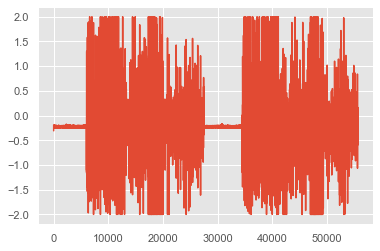

X----shape------ (435, 128)


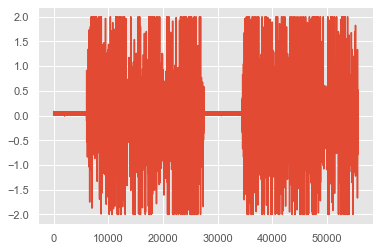

X----shape------ (435, 128)


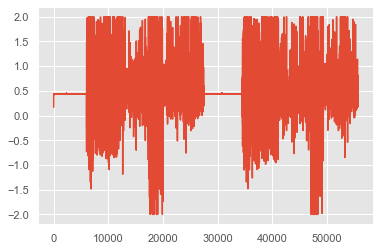

X----shape------ (435, 128)


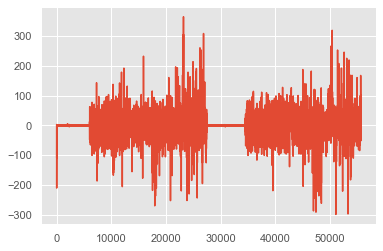

X----shape------ (435, 128)


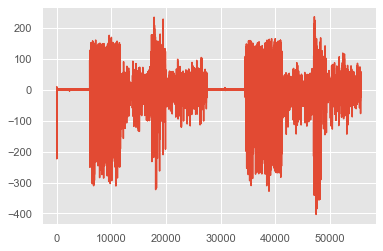

X----shape------ (435, 128)


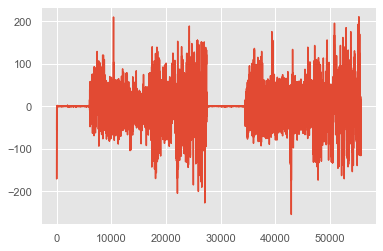

X----shape------ (435, 128)


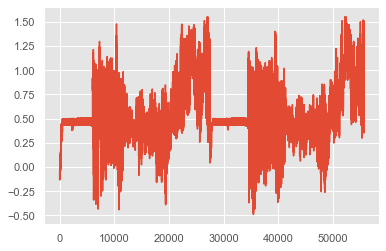

X----shape------ (435, 128)


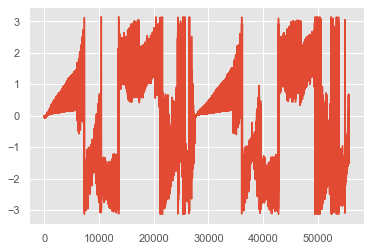

X----shape------ (435, 128)


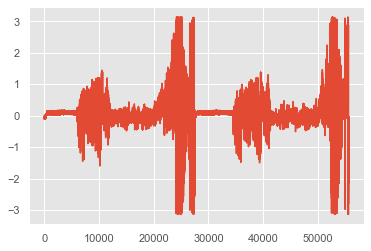

X----shape------ (435, 128)


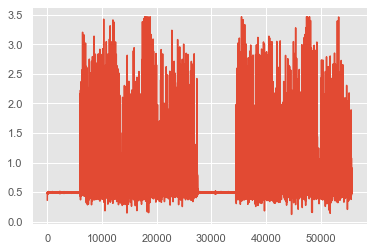

X----shape------ (435, 128)


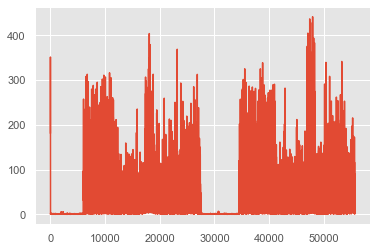

X----shape------ (435, 128)


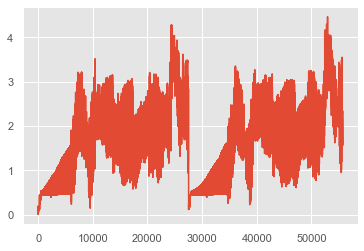

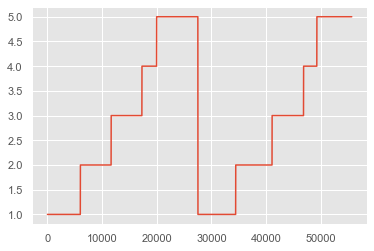

---------------------END GRAPH for 1ZstYhEKzKKfGnMW-------------------
--------------------------------------------------------


In [43]:
uS = unique_subjects[3]
print('----------------------------------------------------------')
print('---------------------START GRAPH for {}-------------------'.format(uS))
X_by_subject, y_by_subject = data_for_subject(X, y, subjects, uS)
y_val_out = []
for i in range(12):
    value = X_by_subject[:, :, i]
    x_val, y_val = get_plot_values(value, y_by_subject)
    y_val_out = y_val
    plt.plot(x_val)
    plt.show()
# res_acc_mean_val = get_mean_values(X, 9)
# plt.plot(res_acc_mean_val)
# plt.show()
# res_gy_mean_val = get_mean_values(X,10)
# plt.plot(res_gy_mean_val)
# plt.show()
# res_angle_mean_val = get_mean_values(X, 11)
# plt.plot(res_angle_mean_val)
# plt.show()
plt.plot(y_val_out)
plt.rcParams["figure.figsize"] = (100, 10)
plt.show()
print('---------------------END GRAPH for {}-------------------'.format(uS))
print('--------------------------------------------------------')



In [44]:
def data_by_activity(X, y, activities):
    # group windows by activity
    return {a:X[y[:,0]==a, :, :] for a in activities}

def groupByActivityBySubjectId(X, y, subjects, subjectId):
    subX, suby = data_for_subject(X, y, subjects, subjectId)
    # get a list of unique activities for the subject
    activity_ids = np.unique(y[:,0])
    grouped = data_by_activity(subX, suby, activity_ids)
    return grouped, activity_ids

zOmNofnVfbR21Y7n
(901, 128, 12)
(176, 128, 12)
(217, 128, 12)
(196, 128, 12)
(119, 128, 12)
(193, 128, 12)


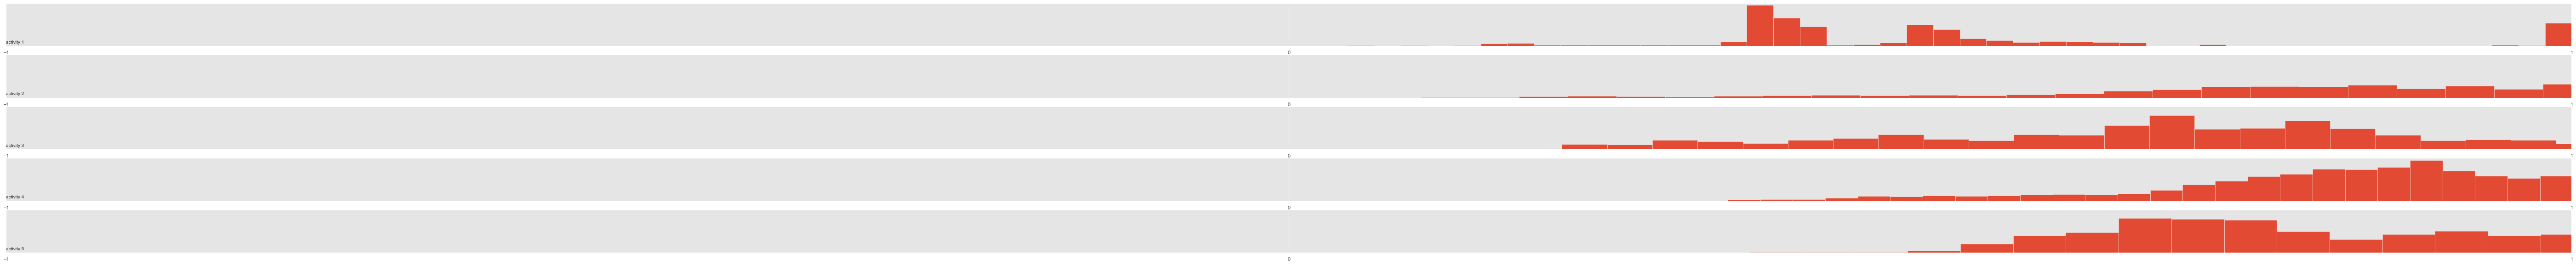

In [45]:
sub_id = unique_subjects[29]
print(sub_id)
groupedData, activity_ids = groupByActivityBySubjectId(X, y, subjects, sub_id)
print(groupedData['1'].shape)
print(groupedData['2'].shape)
print(groupedData['3'].shape)
print(groupedData['4'].shape)
print(groupedData['5'].shape)
data_channel = 11
plt.figure()
for k in range(len(activity_ids)):
    act_id = activity_ids[k]
    ax = plt.subplot(len(activity_ids), 1, k+1)
    ax.set_xlim(-1,1)
    # create histogra,
    plt.hist(get_x_plot_values(groupedData[act_id][:,:,data_channel]), bins=100)
    # create title
    plt.title('activity '+str(act_id), y=0, loc='left', size=10)
    # simplify axis
    plt.yticks([])
    plt.xticks([-1,0,1])
plt.rcParams["figure.figsize"] = (30, 10)

plt.show()

bad IDs

'0DXZFsYOfgqsYe0Z',
'0UXFxu10k0En1vDK',
'KNmC3LADpLyH5qJA',
'WAb2Ztvv2ux95P4Q',   ????,
'YbJVcb4vFFjKKlfe',
'ewpnQDEzR8hTqPRY',
'kPNKVxgIznp3Vskg',   ????,
'qyP4saGxcV9UfeQI',   ????,